In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
from google.colab import files
uploaded = files.upload()

# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

print("Summary of dataGene:\n",dataGene.describe())


Saving TrainingData.csv to TrainingData.csv
Summary of dataGene:
        log_2FoldChange            ET  CoExpression           PCC  \
count     41110.000000  41110.000000  41110.000000  41110.000000   
mean         -0.037332      1.407395      0.991997     -0.361737   
std           0.391444      0.784327      0.089101      0.463979   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.747963   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.051646   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling  \
count  41110.000000        41110.000000        41110.000000   
mean       0.914668           -0.522040           -0.646982   
std        0.279379            0.498568            0.393549   
min        0.000000           -1.000000           -1.000000   
25%   

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in RF feature selection method
feature_names = ['Root10DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot10DaysSeedling', 'Shoot35DaysSeedling', 'Root35DaysSeedling', 
                 'Leaf21DaysSeedling', 'Root14DaysSeedling', 'Shoot3DaysSeedling', 'Root24DaysSeedling', 'Root52DaysSeedling', 
                 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot14DaysSeedling', 'Shoot21DaysSeedling', 'Shoot17DaysSeedling',
                  'ET', 'PCC', 'log_2FoldChange', 'PPI', 'CoExpression' ]

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
print("Summary of X:\n",X_fs.describe())
print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
Summary of X:
        Root10DaysSeedling  Leaf45DaysOldPlant  Shoot10DaysSeedling  \
count        41110.000000        41110.000000         41110.000000   
mean            -0.522040           -0.585144            -0.545055   
std              0.498568            0.399046             0.477438   
min             -1.000000           -1.000000            -1.000000   
25%             -0.901371           -0.901444            -0.906055   
50%             -0.663664           -0.643376            -0.698864   
75%             -0.378497           -0.451900            -0.250588   
max              1.000000            1.000000             1.000000   

       Shoot35DaysSeedling  Root35DaysSeedling  Leaf21DaysSeedling  \
count         41110.000000        41110.000000        41110.000000   
mean             -0.558906           -0.596196           -0.828778   
std               0.506423            0.461679            0.327542   
min              -1.000000 

Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


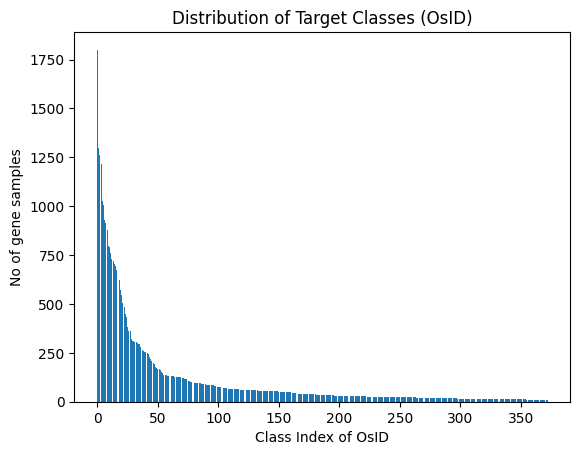

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=60, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Number of input features: 1
Fold: 1
Epoch 1/60
1846/1846 [==============================] - 7s 3ms/step - loss: 5.0109 - accuracy: 0.0382 - val_loss: 4.9468 - val_accuracy: 0.0436
Epoch 2/60
1846/1846 [==============================] - 4s 2ms/step - loss: 4.5126 - accuracy: 0.0959 - val_loss: 4.2355 - val_accuracy: 0.1096
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.9320 - accuracy: 0.1353 - val_loss: 3.8736 - val_accuracy: 0.1626
Epoch 4/60
1846/1846 [==============================] - 4s 2ms/step - loss: 3.5982 - accuracy: 0.1785 - val_loss: 3.6164 - val_accuracy: 0.1743
Epoch 5/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.3409 - accuracy: 0.2234 - val_loss: 3.4487 - val_accuracy: 0.2099
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1369 - accuracy: 0.2484 - val_loss: 3.2595 - val_accuracy: 0.2286
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9883 - accuracy: 0.267

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 5.0209 - accuracy: 0.0421 - val_loss: 4.9583 - val_accuracy: 0.0328
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 4.4363 - accuracy: 0.0943 - val_loss: 4.2140 - val_accuracy: 0.1386
Epoch 3/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.9174 - accuracy: 0.1385 - val_loss: 3.9366 - val_accuracy: 0.1767
Epoch 4/60
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6196 - accuracy: 0.1870 - val_loss: 3.7058 - val_accuracy: 0.2370
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3548 - accuracy: 0.2298 - val_loss: 3.5336 - val_accuracy: 0.1886
Epoch 6/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.1349 - accuracy: 0.2599 - val_loss: 3.3884 - val_accuracy: 0.2521
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9649 - accuracy: 0.2809 - val_loss: 3.2636 - val_accuracy: 0.3639
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.9632 - accuracy: 0.0483 - val_loss: 4.5988 - val_accuracy: 0.0906
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 4.0209 - accuracy: 0.1561 - val_loss: 3.6392 - val_accuracy: 0.3162
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0947 - accuracy: 0.3642 - val_loss: 2.8941 - val_accuracy: 0.4158
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4649 - accuracy: 0.4524 - val_loss: 2.4116 - val_accuracy: 0.4832
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0255 - accuracy: 0.5222 - val_loss: 2.0664 - val_accuracy: 0.5494
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7111 - accuracy: 0.5745 - val_loss: 1.8780 - val_accuracy: 0.5591
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5145 - accuracy: 0.6100 - val_loss: 1.6950 - val_accuracy: 0.6605
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 5.0133 - accuracy: 0.0407 - val_loss: 4.9033 - val_accuracy: 0.0440
Epoch 2/60
1846/1846 [==============================] - 6s 3ms/step - loss: 4.4645 - accuracy: 0.1030 - val_loss: 4.3014 - val_accuracy: 0.1560
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 4.0257 - accuracy: 0.1571 - val_loss: 4.0553 - val_accuracy: 0.1886
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.8070 - accuracy: 0.1699 - val_loss: 3.9376 - val_accuracy: 0.1848
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6436 - accuracy: 0.1902 - val_loss: 3.7853 - val_accuracy: 0.2295
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4781 - accuracy: 0.2079 - val_loss: 3.6935 - val_accuracy: 0.2407
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3069 - accuracy: 0.2341 - val_loss: 3.5364 - val_accuracy: 0.2748
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 5.0101 - accuracy: 0.0421 - val_loss: 4.7930 - val_accuracy: 0.0750
Epoch 2/60
1846/1846 [==============================] - 6s 3ms/step - loss: 4.3751 - accuracy: 0.0968 - val_loss: 4.2096 - val_accuracy: 0.1232
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6588 - accuracy: 0.2497 - val_loss: 3.3142 - val_accuracy: 0.3408
Epoch 4/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.7606 - accuracy: 0.4340 - val_loss: 2.6723 - val_accuracy: 0.4730
Epoch 5/60
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2047 - accuracy: 0.4998 - val_loss: 2.3142 - val_accuracy: 0.5173
Epoch 6/60
1846/1846 [==============================] - 5s 2ms/step - loss: 1.8576 - accuracy: 0.5502 - val_loss: 2.0681 - val_accuracy: 0.5738
Epoch 7/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6487 - accuracy: 0.5883 - val_loss: 1.9102 - val_accuracy: 0.5828
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.9905 - accuracy: 0.0452 - val_loss: 4.6848 - val_accuracy: 0.0717
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 4.3068 - accuracy: 0.1195 - val_loss: 4.2107 - val_accuracy: 0.1228
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7166 - accuracy: 0.2324 - val_loss: 3.4585 - val_accuracy: 0.3210
Epoch 4/60
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8741 - accuracy: 0.3892 - val_loss: 2.8723 - val_accuracy: 0.4304
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3404 - accuracy: 0.4663 - val_loss: 2.5098 - val_accuracy: 0.5105
Epoch 6/60
1846/1846 [==============================] - 5s 2ms/step - loss: 1.9789 - accuracy: 0.5270 - val_loss: 2.3837 - val_accuracy: 0.5155
Epoch 7/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7428 - accuracy: 0.5786 - val_loss: 2.1681 - val_accuracy: 0.5872
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.9669 - accuracy: 0.0577 - val_loss: 4.6161 - val_accuracy: 0.1199
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 4.0036 - accuracy: 0.2051 - val_loss: 3.6728 - val_accuracy: 0.3102
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.2431 - accuracy: 0.3283 - val_loss: 3.1705 - val_accuracy: 0.3558
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7997 - accuracy: 0.3958 - val_loss: 2.8413 - val_accuracy: 0.4748
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4562 - accuracy: 0.4831 - val_loss: 2.5724 - val_accuracy: 0.5333
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1370 - accuracy: 0.5556 - val_loss: 2.2987 - val_accuracy: 0.5765
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8594 - accuracy: 0.5933 - val_loss: 2.1680 - val_accuracy: 0.5828
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.7621 - accuracy: 0.0697 - val_loss: 4.2599 - val_accuracy: 0.1327
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6197 - accuracy: 0.2744 - val_loss: 3.3093 - val_accuracy: 0.4304
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6440 - accuracy: 0.4795 - val_loss: 2.6688 - val_accuracy: 0.5032
Epoch 4/60
1846/1846 [==============================] - 4s 2ms/step - loss: 1.9986 - accuracy: 0.5703 - val_loss: 2.2882 - val_accuracy: 0.6090
Epoch 5/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6282 - accuracy: 0.6205 - val_loss: 2.1029 - val_accuracy: 0.6220
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3944 - accuracy: 0.6677 - val_loss: 1.9054 - val_accuracy: 0.6455
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2346 - accuracy: 0.6975 - val_loss: 1.7482 - val_accuracy: 0.7036
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/60
1846/1846 [==============================] - 6s 3ms/step - loss: 4.7035 - accuracy: 0.0747 - val_loss: 4.1522 - val_accuracy: 0.1127
Epoch 2/60
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6211 - accuracy: 0.2607 - val_loss: 3.3385 - val_accuracy: 0.4231
Epoch 3/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.7981 - accuracy: 0.4302 - val_loss: 2.7237 - val_accuracy: 0.4614
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1967 - accuracy: 0.5256 - val_loss: 2.3000 - val_accuracy: 0.5600
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7920 - accuracy: 0.6005 - val_loss: 2.0541 - val_accuracy: 0.5921
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5474 - accuracy: 0.6369 - val_loss: 1.8672 - val_accuracy: 0.6101
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3738 - accuracy: 0.6750 - val_loss: 1.7470 - val_accuracy:

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.6546 - accuracy: 0.0781 - val_loss: 4.0738 - val_accuracy: 0.1534
Epoch 2/60
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4929 - accuracy: 0.2874 - val_loss: 3.2827 - val_accuracy: 0.4222
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7183 - accuracy: 0.4393 - val_loss: 2.7913 - val_accuracy: 0.4482
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2009 - accuracy: 0.5043 - val_loss: 2.4212 - val_accuracy: 0.5404
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8114 - accuracy: 0.5773 - val_loss: 2.1371 - val_accuracy: 0.6240
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5521 - accuracy: 0.6273 - val_loss: 2.0157 - val_accuracy: 0.5945
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3779 - accuracy: 0.6637 - val_loss: 1.8996 - val_accuracy: 0.6640
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.7664 - accuracy: 0.0668 - val_loss: 4.2496 - val_accuracy: 0.1078
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6978 - accuracy: 0.2434 - val_loss: 3.3956 - val_accuracy: 0.3305
Epoch 3/60
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8500 - accuracy: 0.4221 - val_loss: 2.7298 - val_accuracy: 0.4794
Epoch 4/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2343 - accuracy: 0.5188 - val_loss: 2.2723 - val_accuracy: 0.5520
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8078 - accuracy: 0.5985 - val_loss: 1.9836 - val_accuracy: 0.6167
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5147 - accuracy: 0.6491 - val_loss: 1.7586 - val_accuracy: 0.6878
Epoch 7/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3166 - accuracy: 0.6818 - val_loss: 1.6197 - val_accuracy: 0.6939
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 2ms/step - loss: 4.6960 - accuracy: 0.0657 - val_loss: 4.1532 - val_accuracy: 0.1549
Epoch 2/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6693 - accuracy: 0.2418 - val_loss: 3.5190 - val_accuracy: 0.3512
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0061 - accuracy: 0.4084 - val_loss: 3.0359 - val_accuracy: 0.4339
Epoch 4/60
1846/1846 [==============================] - 5s 2ms/step - loss: 2.4939 - accuracy: 0.4622 - val_loss: 2.7366 - val_accuracy: 0.4920
Epoch 5/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.1264 - accuracy: 0.5189 - val_loss: 2.4875 - val_accuracy: 0.5030
Epoch 6/60
1846/1846 [==============================] - 4s 2ms/step - loss: 1.8499 - accuracy: 0.5694 - val_loss: 2.3098 - val_accuracy: 0.5780
Epoch 7/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6331 - accuracy: 0.6111 - val_loss: 2.1928 - val_accuracy: 0.6257
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.4924 - accuracy: 0.0787 - val_loss: 3.9943 - val_accuracy: 0.1199
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4951 - accuracy: 0.2351 - val_loss: 3.2470 - val_accuracy: 0.4194
Epoch 3/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.6552 - accuracy: 0.4597 - val_loss: 2.5503 - val_accuracy: 0.5250
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0515 - accuracy: 0.5641 - val_loss: 2.1205 - val_accuracy: 0.5971
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6670 - accuracy: 0.6287 - val_loss: 1.8741 - val_accuracy: 0.6255
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3880 - accuracy: 0.6852 - val_loss: 1.6280 - val_accuracy: 0.7065
Epoch 7/60
1846/1846 [==============================] - 5s 2ms/step - loss: 1.1864 - accuracy: 0.7270 - val_loss: 1.5107 - val_accuracy: 0.7426
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.7533 - accuracy: 0.0636 - val_loss: 4.1236 - val_accuracy: 0.1188
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3866 - accuracy: 0.3079 - val_loss: 3.1232 - val_accuracy: 0.4216
Epoch 3/60
1846/1846 [==============================] - 5s 2ms/step - loss: 2.5114 - accuracy: 0.5016 - val_loss: 2.5051 - val_accuracy: 0.5659
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9511 - accuracy: 0.5853 - val_loss: 2.1790 - val_accuracy: 0.6070
Epoch 5/60
1846/1846 [==============================] - 5s 2ms/step - loss: 1.5956 - accuracy: 0.6402 - val_loss: 1.9708 - val_accuracy: 0.6541
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3762 - accuracy: 0.6779 - val_loss: 1.8149 - val_accuracy: 0.6774
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2223 - accuracy: 0.7027 - val_loss: 1.7749 - val_accuracy: 0.6453
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.5483 - accuracy: 0.0840 - val_loss: 4.0805 - val_accuracy: 0.0911
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5276 - accuracy: 0.2349 - val_loss: 3.2320 - val_accuracy: 0.3287
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6619 - accuracy: 0.4353 - val_loss: 2.5896 - val_accuracy: 0.4876
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0383 - accuracy: 0.5791 - val_loss: 2.0761 - val_accuracy: 0.6040
Epoch 5/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.5741 - accuracy: 0.6581 - val_loss: 1.7343 - val_accuracy: 0.6759
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2614 - accuracy: 0.7131 - val_loss: 1.5703 - val_accuracy: 0.6955
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0770 - accuracy: 0.7390 - val_loss: 1.4182 - val_accuracy: 0.7439
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.5818 - accuracy: 0.0859 - val_loss: 3.9837 - val_accuracy: 0.1087
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4257 - accuracy: 0.2769 - val_loss: 3.2273 - val_accuracy: 0.3804
Epoch 3/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.5715 - accuracy: 0.4717 - val_loss: 2.5156 - val_accuracy: 0.5375
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9161 - accuracy: 0.5873 - val_loss: 2.1432 - val_accuracy: 0.5732
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5344 - accuracy: 0.6466 - val_loss: 1.9263 - val_accuracy: 0.6640
Epoch 6/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.2895 - accuracy: 0.6938 - val_loss: 1.7388 - val_accuracy: 0.7083
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.1212 - accuracy: 0.7288 - val_loss: 1.6223 - val_accuracy: 0.7327
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.5267 - accuracy: 0.0926 - val_loss: 4.0622 - val_accuracy: 0.1353
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.5877 - accuracy: 0.2196 - val_loss: 3.3832 - val_accuracy: 0.3776
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7876 - accuracy: 0.4100 - val_loss: 2.6170 - val_accuracy: 0.4922
Epoch 4/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.0493 - accuracy: 0.5558 - val_loss: 2.0906 - val_accuracy: 0.5459
Epoch 5/60
1846/1846 [==============================] - 5s 2ms/step - loss: 1.5910 - accuracy: 0.6432 - val_loss: 1.7529 - val_accuracy: 0.6631
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2978 - accuracy: 0.6956 - val_loss: 1.5350 - val_accuracy: 0.7039
Epoch 7/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.1185 - accuracy: 0.7268 - val_loss: 1.4325 - val_accuracy: 0.7188
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.5553 - accuracy: 0.0866 - val_loss: 4.0224 - val_accuracy: 0.1292
Epoch 2/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.4571 - accuracy: 0.2683 - val_loss: 3.1148 - val_accuracy: 0.4145
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5017 - accuracy: 0.4887 - val_loss: 2.4333 - val_accuracy: 0.5443
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8929 - accuracy: 0.5948 - val_loss: 2.0128 - val_accuracy: 0.6378
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5141 - accuracy: 0.6655 - val_loss: 1.7568 - val_accuracy: 0.6920
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2754 - accuracy: 0.6971 - val_loss: 1.5922 - val_accuracy: 0.7160
Epoch 7/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.1162 - accuracy: 0.7292 - val_loss: 1.4740 - val_accuracy: 0.7204
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.5272 - accuracy: 0.0819 - val_loss: 4.0794 - val_accuracy: 0.1188
Epoch 2/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5848 - accuracy: 0.1946 - val_loss: 3.3948 - val_accuracy: 0.2405
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7806 - accuracy: 0.4226 - val_loss: 2.6840 - val_accuracy: 0.4757
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0973 - accuracy: 0.5615 - val_loss: 2.1755 - val_accuracy: 0.5844
Epoch 5/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6565 - accuracy: 0.6259 - val_loss: 1.8247 - val_accuracy: 0.6438
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3692 - accuracy: 0.6809 - val_loss: 1.6121 - val_accuracy: 0.6942
Epoch 7/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.1621 - accuracy: 0.7262 - val_loss: 1.4724 - val_accuracy: 0.7230
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/60
1846/1846 [==============================] - 6s 3ms/step - loss: 4.6895 - accuracy: 0.0668 - val_loss: 4.2263 - val_accuracy: 0.0821
Epoch 2/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.7624 - accuracy: 0.1789 - val_loss: 3.6260 - val_accuracy: 0.2583
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1041 - accuracy: 0.3431 - val_loss: 3.0455 - val_accuracy: 0.4139
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5142 - accuracy: 0.4699 - val_loss: 2.6114 - val_accuracy: 0.5373
Epoch 5/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.0514 - accuracy: 0.5592 - val_loss: 2.3170 - val_accuracy: 0.6101
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7070 - accuracy: 0.6169 - val_loss: 2.1257 - val_accuracy: 0.6103
Epoch 7/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4743 - accuracy: 0.6538 - val_loss: 1.9558 - val_accuracy:

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/60
1846/1846 [==============================] - 7s 3ms/step - loss: 4.6539 - accuracy: 0.0749 - val_loss: 4.2366 - val_accuracy: 0.1142
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8358 - accuracy: 0.1639 - val_loss: 3.6929 - val_accuracy: 0.2207
Epoch 3/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.2449 - accuracy: 0.2695 - val_loss: 3.1269 - val_accuracy: 0.3974
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6186 - accuracy: 0.4387 - val_loss: 2.6040 - val_accuracy: 0.5193
Epoch 5/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.1346 - accuracy: 0.5474 - val_loss: 2.2686 - val_accuracy: 0.5688
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7800 - accuracy: 0.6073 - val_loss: 1.9782 - val_accuracy: 0.5855
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5077 - accuracy: 0.6547 - val_loss: 1.7399 - val_accuracy:

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.5774 - accuracy: 0.0745 - val_loss: 4.1603 - val_accuracy: 0.1146
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6839 - accuracy: 0.1610 - val_loss: 3.5508 - val_accuracy: 0.2046
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0026 - accuracy: 0.3379 - val_loss: 2.9090 - val_accuracy: 0.4471
Epoch 4/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.3713 - accuracy: 0.5051 - val_loss: 2.4915 - val_accuracy: 0.5402
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9143 - accuracy: 0.5887 - val_loss: 2.1851 - val_accuracy: 0.5934
Epoch 6/60
1846/1846 [==============================] - 6s 4ms/step - loss: 1.6086 - accuracy: 0.6401 - val_loss: 2.0173 - val_accuracy: 0.6429
Epoch 7/60
1846/1846 [==============================] - 5s 2ms/step - loss: 1.3973 - accuracy: 0.6805 - val_loss: 1.8626 - val_accuracy: 0.6739
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.4350 - accuracy: 0.1015 - val_loss: 4.0072 - val_accuracy: 0.1430
Epoch 2/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5674 - accuracy: 0.1922 - val_loss: 3.3921 - val_accuracy: 0.2497
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8036 - accuracy: 0.3621 - val_loss: 2.5762 - val_accuracy: 0.4565
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0114 - accuracy: 0.5327 - val_loss: 2.0110 - val_accuracy: 0.5536
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5205 - accuracy: 0.6356 - val_loss: 1.6548 - val_accuracy: 0.6464
Epoch 6/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.2277 - accuracy: 0.6963 - val_loss: 1.4128 - val_accuracy: 0.7146
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0412 - accuracy: 0.7337 - val_loss: 1.2837 - val_accuracy: 0.7331
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.5224 - accuracy: 0.0842 - val_loss: 4.0652 - val_accuracy: 0.1729
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5724 - accuracy: 0.1932 - val_loss: 3.4375 - val_accuracy: 0.2233
Epoch 3/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.9871 - accuracy: 0.2968 - val_loss: 2.9420 - val_accuracy: 0.4436
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4117 - accuracy: 0.4683 - val_loss: 2.4680 - val_accuracy: 0.5030
Epoch 5/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.9477 - accuracy: 0.5770 - val_loss: 2.1830 - val_accuracy: 0.6103
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6012 - accuracy: 0.6459 - val_loss: 1.9470 - val_accuracy: 0.6684
Epoch 7/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3431 - accuracy: 0.7001 - val_loss: 1.7480 - val_accuracy: 0.7109
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 8s 4ms/step - loss: 4.5718 - accuracy: 0.0854 - val_loss: 4.1390 - val_accuracy: 0.1353
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6510 - accuracy: 0.1746 - val_loss: 3.4330 - val_accuracy: 0.2295
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9222 - accuracy: 0.3406 - val_loss: 2.7505 - val_accuracy: 0.4548
Epoch 4/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2336 - accuracy: 0.5076 - val_loss: 2.2242 - val_accuracy: 0.5547
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7502 - accuracy: 0.6136 - val_loss: 1.8597 - val_accuracy: 0.6473
Epoch 6/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4285 - accuracy: 0.6717 - val_loss: 1.6277 - val_accuracy: 0.6785
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2144 - accuracy: 0.7104 - val_loss: 1.5120 - val_accuracy: 0.7039
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.4906 - accuracy: 0.1000 - val_loss: 4.0747 - val_accuracy: 0.1340
Epoch 2/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6019 - accuracy: 0.2045 - val_loss: 3.4628 - val_accuracy: 0.2697
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8661 - accuracy: 0.3948 - val_loss: 2.7444 - val_accuracy: 0.5105
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.2127 - accuracy: 0.5354 - val_loss: 2.3248 - val_accuracy: 0.5441
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7690 - accuracy: 0.6135 - val_loss: 1.9793 - val_accuracy: 0.6308
Epoch 6/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4644 - accuracy: 0.6680 - val_loss: 1.7557 - val_accuracy: 0.6801
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2639 - accuracy: 0.7028 - val_loss: 1.6328 - val_accuracy: 0.7023
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.5096 - accuracy: 0.0862 - val_loss: 3.9626 - val_accuracy: 0.1340
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4812 - accuracy: 0.2077 - val_loss: 3.2889 - val_accuracy: 0.2477
Epoch 3/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.8428 - accuracy: 0.3349 - val_loss: 2.7256 - val_accuracy: 0.3883
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2492 - accuracy: 0.5119 - val_loss: 2.2293 - val_accuracy: 0.5844
Epoch 5/60
1846/1846 [==============================] - 7s 4ms/step - loss: 1.7868 - accuracy: 0.6132 - val_loss: 1.8660 - val_accuracy: 0.6328
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4816 - accuracy: 0.6599 - val_loss: 1.6568 - val_accuracy: 0.6587
Epoch 7/60
1846/1846 [==============================] - 6s 4ms/step - loss: 1.2756 - accuracy: 0.6949 - val_loss: 1.5038 - val_accuracy: 0.6981
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.4846 - accuracy: 0.0832 - val_loss: 3.9922 - val_accuracy: 0.1582
Epoch 2/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5317 - accuracy: 0.1985 - val_loss: 3.3706 - val_accuracy: 0.2546
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9247 - accuracy: 0.3259 - val_loss: 2.8200 - val_accuracy: 0.4442
Epoch 4/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2717 - accuracy: 0.4833 - val_loss: 2.2956 - val_accuracy: 0.5424
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7443 - accuracy: 0.6038 - val_loss: 1.9519 - val_accuracy: 0.6315
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4155 - accuracy: 0.6691 - val_loss: 1.7142 - val_accuracy: 0.6926
Epoch 7/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.1869 - accuracy: 0.7166 - val_loss: 1.5719 - val_accuracy: 0.7318
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.7086 - accuracy: 0.0713 - val_loss: 4.2095 - val_accuracy: 0.1025
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8074 - accuracy: 0.1553 - val_loss: 3.6742 - val_accuracy: 0.1692
Epoch 3/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.2786 - accuracy: 0.2339 - val_loss: 3.2396 - val_accuracy: 0.2647
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7415 - accuracy: 0.3938 - val_loss: 2.6914 - val_accuracy: 0.4706
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2083 - accuracy: 0.5219 - val_loss: 2.2990 - val_accuracy: 0.5776
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8430 - accuracy: 0.5926 - val_loss: 2.0334 - val_accuracy: 0.6207
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5888 - accuracy: 0.6364 - val_loss: 1.8356 - val_accuracy: 0.6418
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.6779 - accuracy: 0.0597 - val_loss: 4.2232 - val_accuracy: 0.0939
Epoch 2/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.7992 - accuracy: 0.1561 - val_loss: 3.6161 - val_accuracy: 0.2183
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1097 - accuracy: 0.3349 - val_loss: 3.0377 - val_accuracy: 0.4398
Epoch 4/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4798 - accuracy: 0.5057 - val_loss: 2.5963 - val_accuracy: 0.5263
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0100 - accuracy: 0.5578 - val_loss: 2.2858 - val_accuracy: 0.5826
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6778 - accuracy: 0.6314 - val_loss: 2.1567 - val_accuracy: 0.6077
Epoch 7/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4574 - accuracy: 0.6752 - val_loss: 1.9593 - val_accuracy: 0.6572
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.7662 - accuracy: 0.0596 - val_loss: 4.3111 - val_accuracy: 0.1226
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.9426 - accuracy: 0.1559 - val_loss: 3.7932 - val_accuracy: 0.1681
Epoch 3/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5184 - accuracy: 0.1934 - val_loss: 3.4686 - val_accuracy: 0.1855
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1547 - accuracy: 0.2567 - val_loss: 3.1119 - val_accuracy: 0.2557
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7244 - accuracy: 0.3769 - val_loss: 2.7041 - val_accuracy: 0.4145
Epoch 6/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.3167 - accuracy: 0.4741 - val_loss: 2.3788 - val_accuracy: 0.4563
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0055 - accuracy: 0.5393 - val_loss: 2.1610 - val_accuracy: 0.5604
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.7379 - accuracy: 0.0717 - val_loss: 4.3156 - val_accuracy: 0.1430
Epoch 2/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.8981 - accuracy: 0.1538 - val_loss: 3.7805 - val_accuracy: 0.2033
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4831 - accuracy: 0.2013 - val_loss: 3.4761 - val_accuracy: 0.2484
Epoch 4/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.1013 - accuracy: 0.2739 - val_loss: 3.0869 - val_accuracy: 0.3470
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6268 - accuracy: 0.3818 - val_loss: 2.6485 - val_accuracy: 0.4191
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1785 - accuracy: 0.4943 - val_loss: 2.3250 - val_accuracy: 0.4823
Epoch 7/60
1846/1846 [==============================] - 6s 3ms/step - loss: 1.8481 - accuracy: 0.5759 - val_loss: 2.0477 - val_accuracy: 0.6092
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.7116 - accuracy: 0.0710 - val_loss: 4.2265 - val_accuracy: 0.1243
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8666 - accuracy: 0.1513 - val_loss: 3.7320 - val_accuracy: 0.1459
Epoch 3/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.4020 - accuracy: 0.2051 - val_loss: 3.3001 - val_accuracy: 0.2548
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8844 - accuracy: 0.3292 - val_loss: 2.7795 - val_accuracy: 0.3817
Epoch 5/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.3989 - accuracy: 0.4355 - val_loss: 2.4333 - val_accuracy: 0.4680
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0799 - accuracy: 0.5049 - val_loss: 2.1899 - val_accuracy: 0.5270
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8719 - accuracy: 0.5468 - val_loss: 2.0339 - val_accuracy: 0.5604
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.9298 - accuracy: 0.0527 - val_loss: 4.6798 - val_accuracy: 0.0634
Epoch 2/60
1846/1846 [==============================] - 6s 3ms/step - loss: 4.1531 - accuracy: 0.1124 - val_loss: 3.9482 - val_accuracy: 0.1556
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5882 - accuracy: 0.1808 - val_loss: 3.5319 - val_accuracy: 0.2275
Epoch 4/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.1530 - accuracy: 0.2556 - val_loss: 3.1200 - val_accuracy: 0.3177
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6729 - accuracy: 0.3743 - val_loss: 2.6737 - val_accuracy: 0.4200
Epoch 6/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.2961 - accuracy: 0.4621 - val_loss: 2.4008 - val_accuracy: 0.4807
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0502 - accuracy: 0.5069 - val_loss: 2.2159 - val_accuracy: 0.5287
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/60
1846/1846 [==============================] - 7s 3ms/step - loss: 4.8264 - accuracy: 0.0589 - val_loss: 4.4389 - val_accuracy: 0.0671
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 4.0190 - accuracy: 0.1409 - val_loss: 3.8723 - val_accuracy: 0.1701
Epoch 3/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5480 - accuracy: 0.1950 - val_loss: 3.5023 - val_accuracy: 0.2440
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1108 - accuracy: 0.2729 - val_loss: 3.0090 - val_accuracy: 0.3105
Epoch 5/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6082 - accuracy: 0.3891 - val_loss: 2.5916 - val_accuracy: 0.4130
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2558 - accuracy: 0.4557 - val_loss: 2.3393 - val_accuracy: 0.4708
Epoch 7/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0084 - accuracy: 0.5046 - val_loss: 2.1539 - val_accuracy:

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.7606 - accuracy: 0.0659 - val_loss: 4.2906 - val_accuracy: 0.1138
Epoch 2/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.8954 - accuracy: 0.1500 - val_loss: 3.7792 - val_accuracy: 0.1663
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4084 - accuracy: 0.2060 - val_loss: 3.3116 - val_accuracy: 0.2579
Epoch 4/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.8636 - accuracy: 0.3549 - val_loss: 2.8491 - val_accuracy: 0.4106
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4183 - accuracy: 0.4412 - val_loss: 2.5873 - val_accuracy: 0.4257
Epoch 6/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1429 - accuracy: 0.4881 - val_loss: 2.3542 - val_accuracy: 0.5113
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9391 - accuracy: 0.5333 - val_loss: 2.2012 - val_accuracy: 0.5397
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.7946 - accuracy: 0.0579 - val_loss: 4.2917 - val_accuracy: 0.0766
Epoch 2/60
1846/1846 [==============================] - 7s 4ms/step - loss: 3.9145 - accuracy: 0.1475 - val_loss: 3.7397 - val_accuracy: 0.1791
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3920 - accuracy: 0.2186 - val_loss: 3.2481 - val_accuracy: 0.2737
Epoch 4/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.8654 - accuracy: 0.3228 - val_loss: 2.7479 - val_accuracy: 0.3793
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4273 - accuracy: 0.4195 - val_loss: 2.4310 - val_accuracy: 0.4737
Epoch 6/60
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1267 - accuracy: 0.4843 - val_loss: 2.1679 - val_accuracy: 0.5210
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8872 - accuracy: 0.5359 - val_loss: 1.9819 - val_accuracy: 0.5496
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.8190 - accuracy: 0.0572 - val_loss: 4.4070 - val_accuracy: 0.0702
Epoch 2/60
1846/1846 [==============================] - 6s 4ms/step - loss: 3.9979 - accuracy: 0.1377 - val_loss: 3.8856 - val_accuracy: 0.1751
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5942 - accuracy: 0.1903 - val_loss: 3.6002 - val_accuracy: 0.1949
Epoch 4/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.2336 - accuracy: 0.2447 - val_loss: 3.2183 - val_accuracy: 0.2603
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8261 - accuracy: 0.3293 - val_loss: 2.8518 - val_accuracy: 0.3745
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4477 - accuracy: 0.4071 - val_loss: 2.5561 - val_accuracy: 0.4218
Epoch 7/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.1468 - accuracy: 0.4748 - val_loss: 2.2989 - val_accuracy: 0.4823
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 4.7924 - accuracy: 0.0623 - val_loss: 4.3241 - val_accuracy: 0.1023
Epoch 2/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.9250 - accuracy: 0.1539 - val_loss: 3.7942 - val_accuracy: 0.1679
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4785 - accuracy: 0.2029 - val_loss: 3.4378 - val_accuracy: 0.2242
Epoch 4/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.0871 - accuracy: 0.2770 - val_loss: 3.0662 - val_accuracy: 0.3127
Epoch 5/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6224 - accuracy: 0.3866 - val_loss: 2.6440 - val_accuracy: 0.4310
Epoch 6/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2546 - accuracy: 0.4690 - val_loss: 2.3586 - val_accuracy: 0.4453
Epoch 7/60
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0129 - accuracy: 0.5150 - val_loss: 2.1443 - val_accuracy: 0.5267
Epo

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/60
1846/1846 [==============================] - 6s 3ms/step - loss: 4.7972 - accuracy: 0.0613 - val_loss: 4.5088 - val_accuracy: 0.1100
Epoch 2/60
1846/1846 [==============================] - 6s 3ms/step - loss: 4.0920 - accuracy: 0.1264 - val_loss: 3.9460 - val_accuracy: 0.1784
Epoch 3/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6352 - accuracy: 0.1769 - val_loss: 3.6695 - val_accuracy: 0.2048
Epoch 4/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3755 - accuracy: 0.2045 - val_loss: 3.4868 - val_accuracy: 0.2183
Epoch 5/60
1846/1846 [==============================] - 6s 3ms/step - loss: 3.1849 - accuracy: 0.2415 - val_loss: 3.3275 - val_accuracy: 0.2158
Epoch 6/60
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0056 - accuracy: 0.2636 - val_loss: 3.1159 - val_accuracy: 0.2519
Epoch 7/60
1846/1846 [==============================] - 6s 3ms/step - loss: 2.8307 - accuracy: 0.2922 - val_loss: 2.9636 - val_accuracy:

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

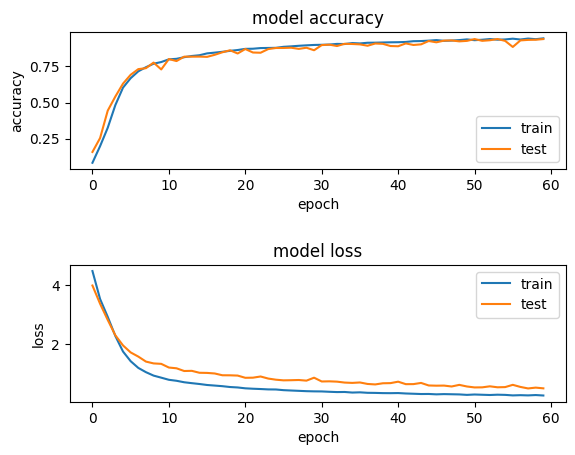

Final Test Accuracy: 0.9499520659446716


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os04g0475500         328              280       False
1  Os04g0659100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.483
1,2,0.808
2,3,0.801
3,4,0.899
4,5,0.863
5,6,0.856
6,7,0.927
7,8,0.893
8,9,0.934
9,10,0.900
